Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [18]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from models import *

import torch
import torch.optim

# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [19]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png' # 512, 512

# Load image

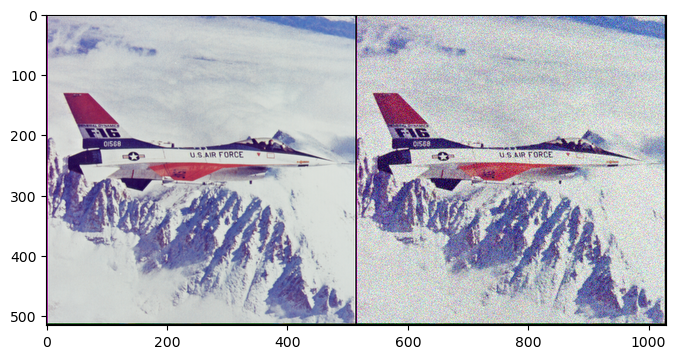

In [44]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

In [5]:
img_noisy_np = img_noisy_np[0:1,:,:]
img_noisy_np.shape

(1, 512, 512)

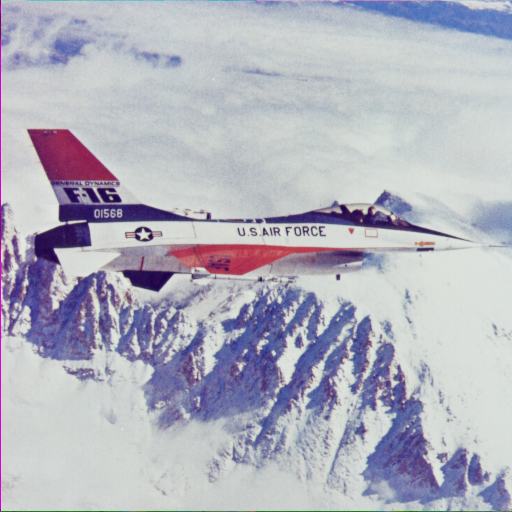

In [51]:
img_pil

In [6]:
img_np = img_np[0:1,:,:]

# Setup

In [7]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad, n_channels=1,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217573


# Optimize

Starting optimization with ADAM


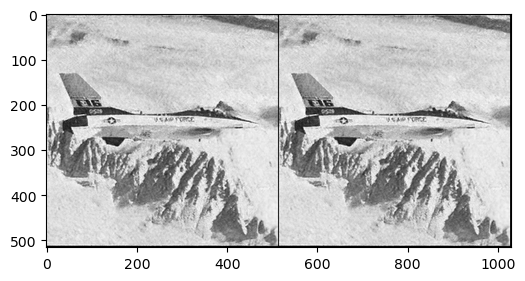

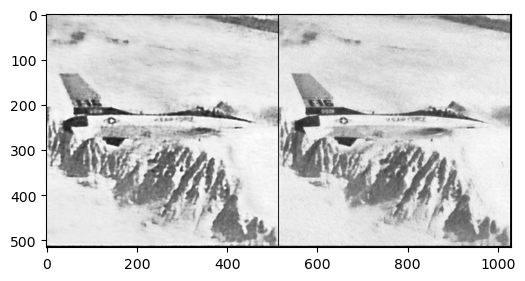

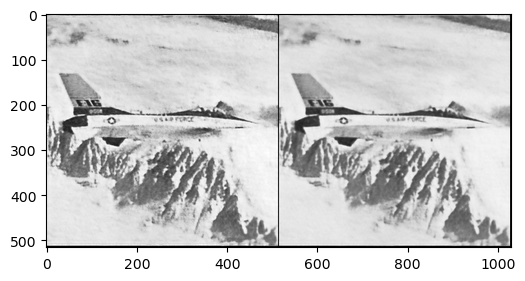

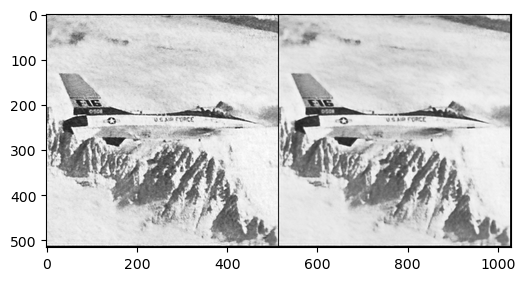

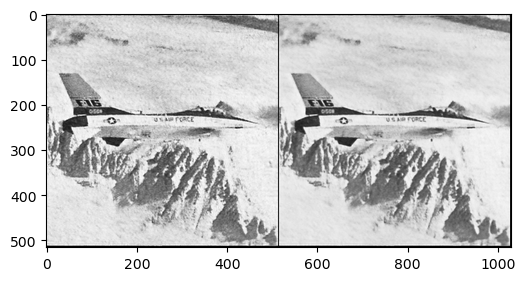

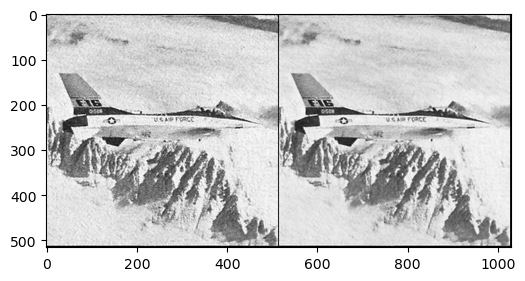

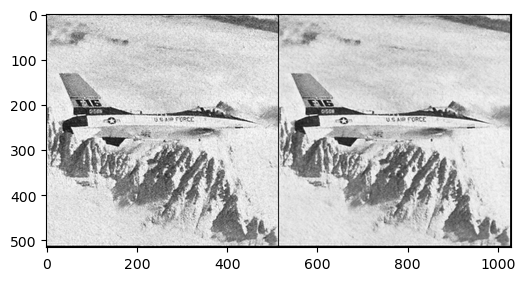

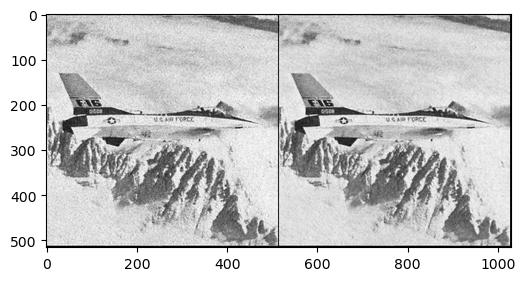

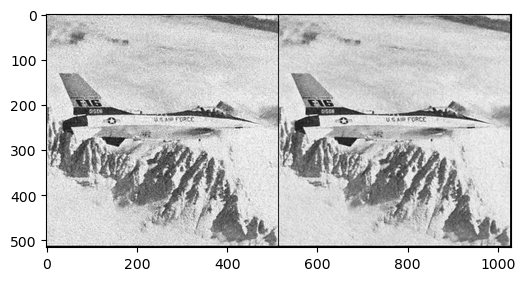

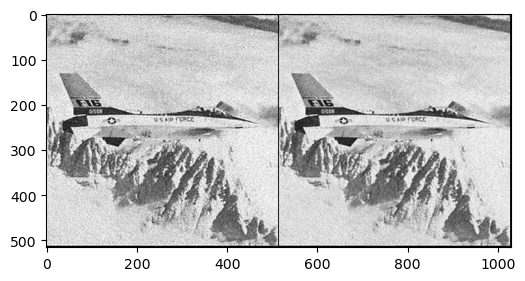

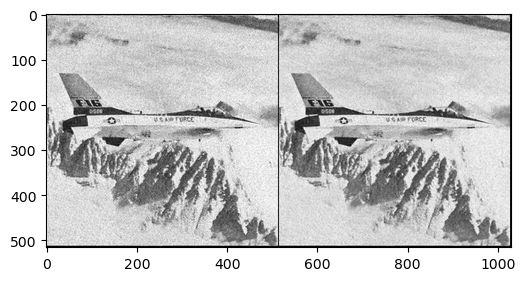

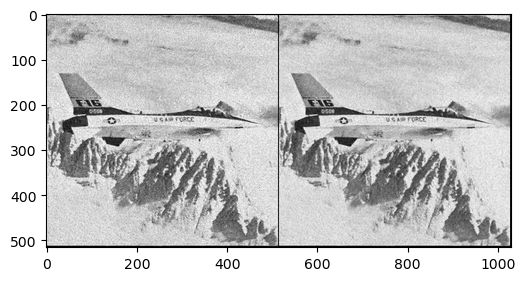

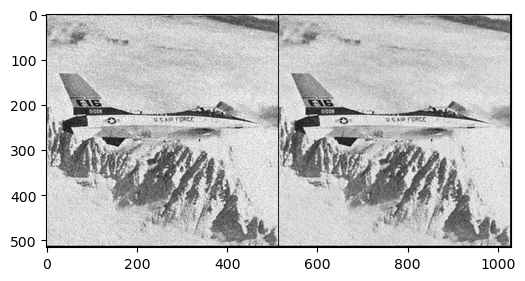

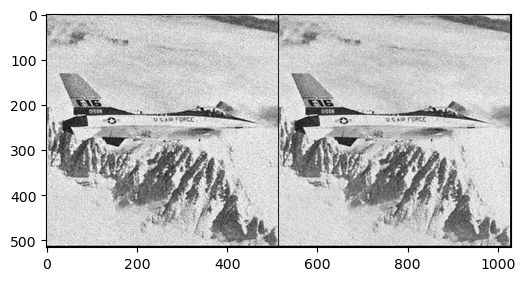

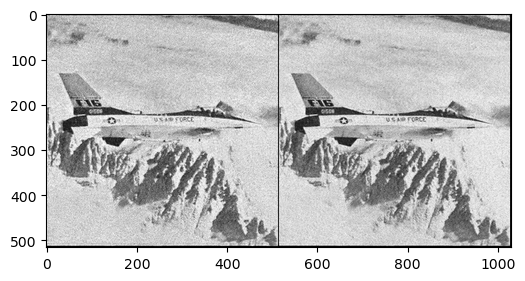

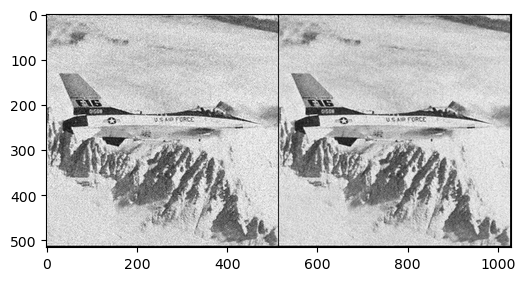

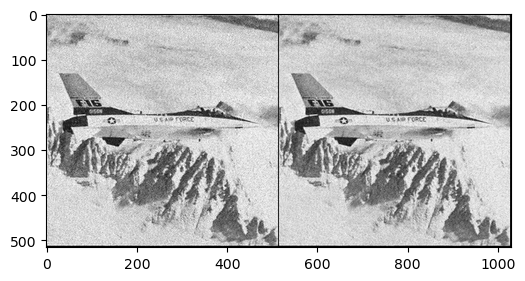

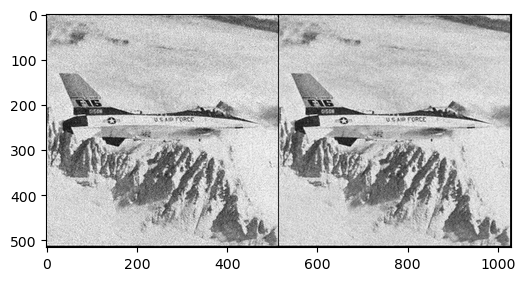

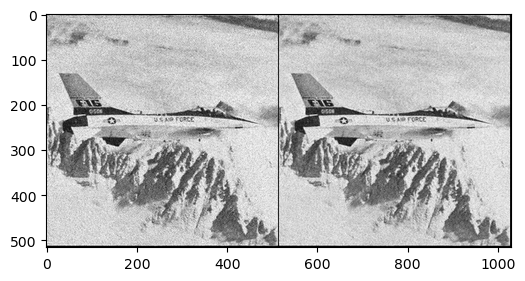

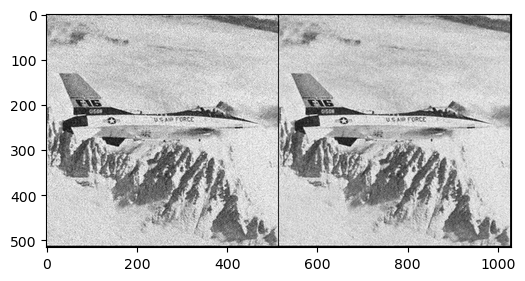

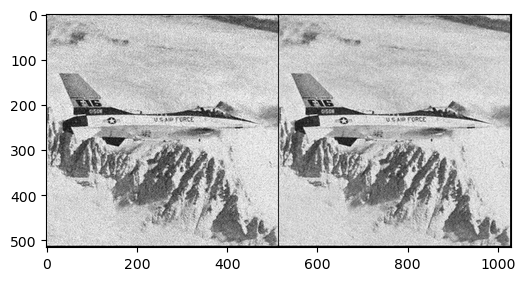

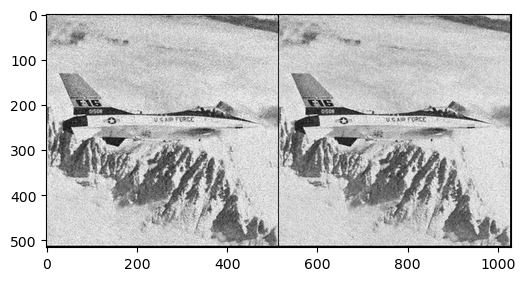

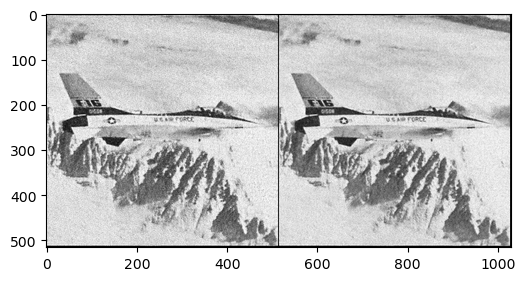

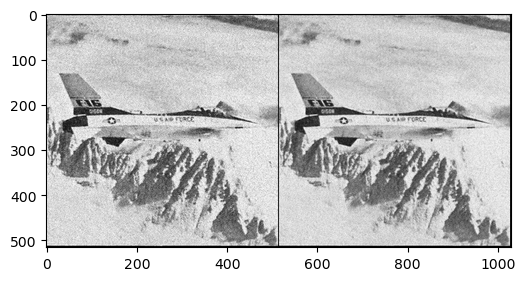

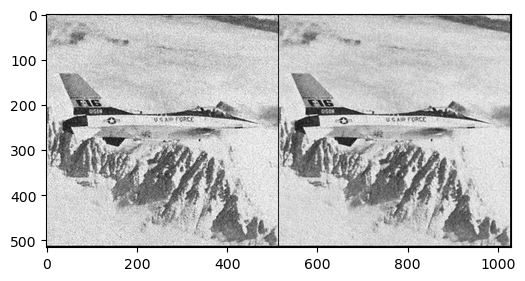

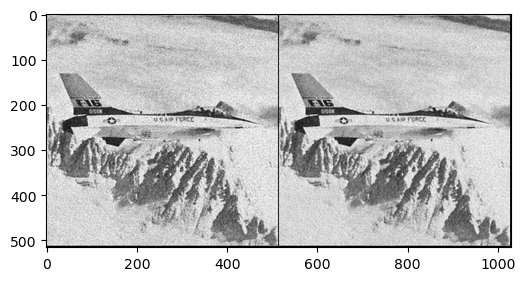

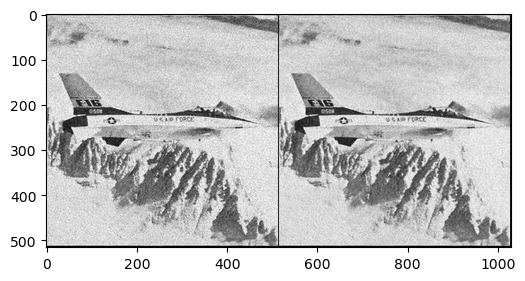

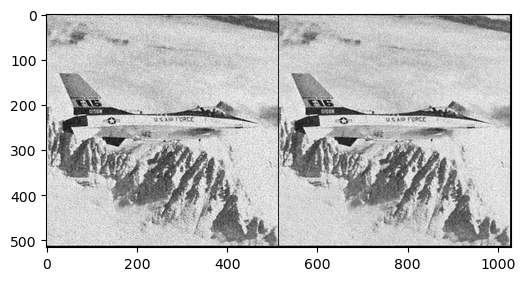

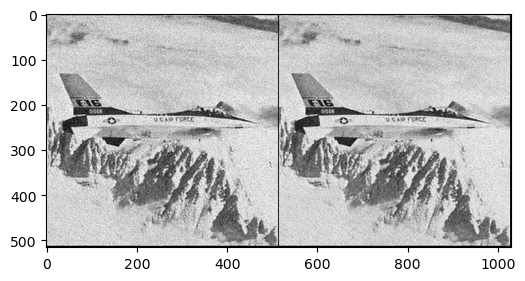

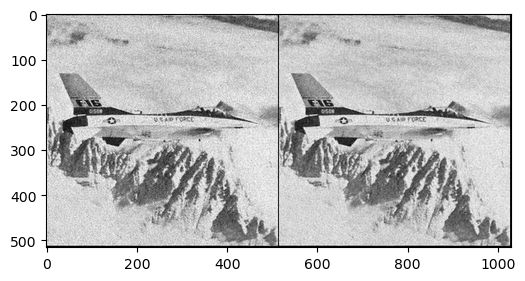

In [10]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    psrn_noisy = psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=2)
                    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

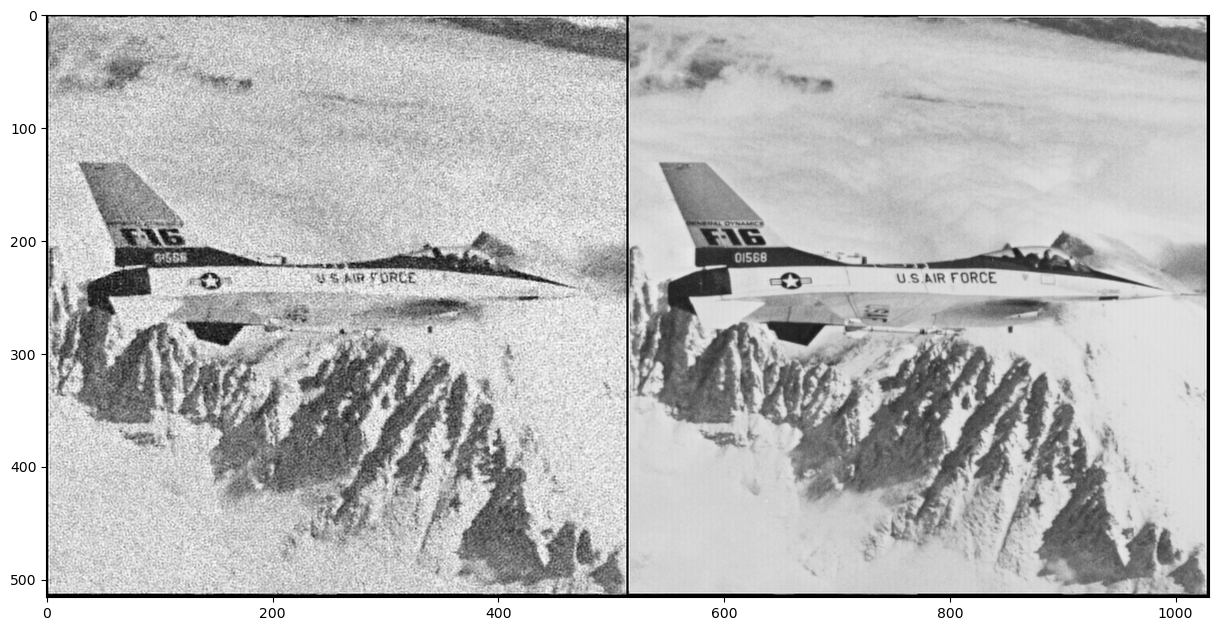

In [11]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [12]:
layer_name_contains = None
for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d):
        # print('True')
        # If filtering, skip layers that don't match
        if layer_name_contains is not None and layer_name_contains not in name:
            continue
        found_layer = True
        # Print for debugging
        print("Found Conv2d layer:", name, module.kernel_size)
              # .weight.shape)
    

Found Conv2d layer: 1.0.1.1 (1, 1)
Found Conv2d layer: 1.1.1.1 (3, 3)
Found Conv2d layer: 1.1.4.1 (3, 3)
Found Conv2d layer: 1.1.7.1.0.1.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.1.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.4.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.0.1.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.7.1.1.1.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.4.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.0.1.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.1.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.4.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.7.1.0.1.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.7.1.1.1.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.7.1.1.4.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.7.3.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.1.1.7.6.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.3.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.1.1.7.6.1 (1, 1)
Found Conv2d layer: 1.1.7.1.1.7.3.1 (3, 3)
Found Conv2d layer: 1.1.7.1.1.7.6.1 (1, 1)
F

In [ ]:
psnr

Found Conv2d layer: 3.1 with weight shape torch.Size([128, 132, 3, 3])


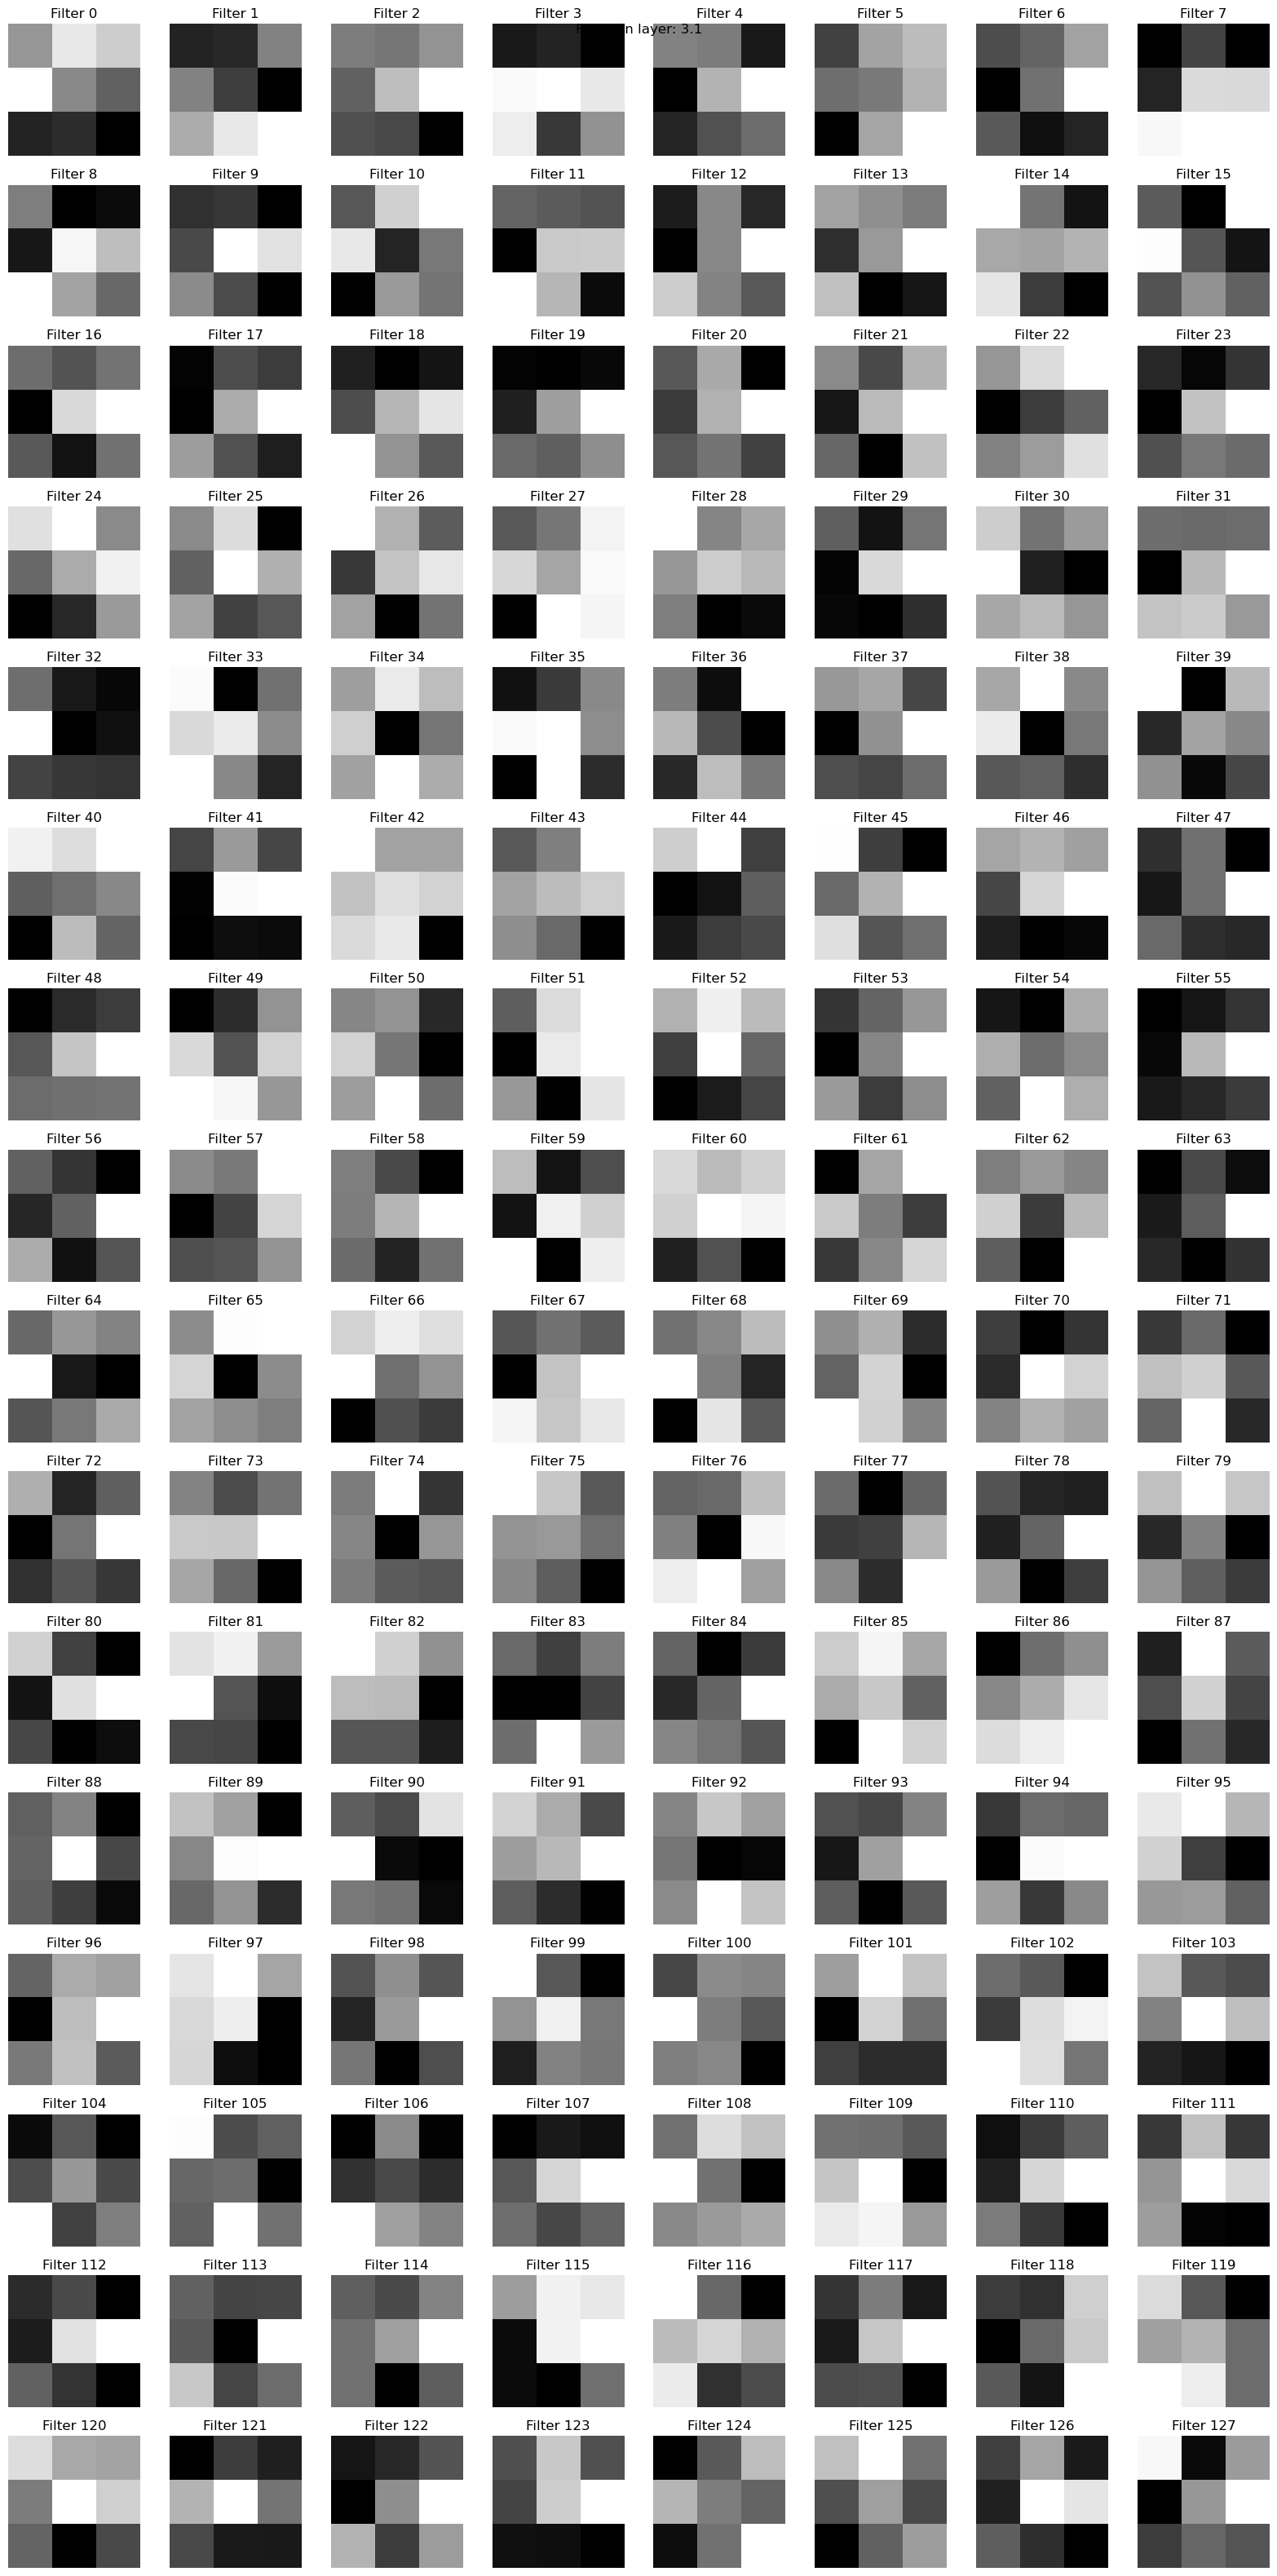

In [13]:
import re
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

def visualize_conv_filters_by_exact_name(model, target_name="3.1"):
    # Compile a regex that matches exactly the target_name
    pattern = re.compile(rf"^{re.escape(target_name)}$")
    found_layer = False
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # Use fullmatch to check for an exact match
            if pattern.fullmatch(name):
                found_layer = True
                print(f"Found Conv2d layer: {name} with weight shape {module.weight.shape}")
                # Extract weights: shape = (out_channels, in_channels, kH, kW)
                weights = module.weight.data.cpu()
                out_channels, in_channels, kH, kW = weights.shape
                # Average over input channels for visualization
                filters = weights.mean(dim=1)  # shape: (out_channels, kH, kW)
                
                n_cols = min(out_channels, 8)
                n_rows = (out_channels + n_cols - 1) // n_cols
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
                if n_rows == 1 and n_cols == 1:
                    axes = [axes]
                else:
                    axes = axes.flatten()
                
                for i in range(out_channels):
                    filt = filters[i].numpy()
                    # Normalize filter values to [0, 1] for visualization
                    filt_min, filt_max = filt.min(), filt.max()
                    if filt_max - filt_min < 1e-8:
                        filt_norm = np.zeros_like(filt)
                    else:
                        filt_norm = (filt - filt_min) / (filt_max - filt_min)
                    axes[i].imshow(filt_norm, cmap='gray')
                    axes[i].set_title(f"Filter {i}")
                    axes[i].axis('off')
                # Hide any extra subplots
                for j in range(out_channels, len(axes)):
                    axes[j].axis('off')
                
                plt.suptitle(f"Filters in layer: {name}")
                plt.tight_layout()
                plt.show()
    if not found_layer:
        print(f"No Conv2d layers found with name exactly '{target_name}'.")

# Example usage:
visualize_conv_filters_by_exact_name(net, target_name="3.1")


Found Conv2d layer: 1.1.7.3.1 with weight shape torch.Size([128, 132, 3, 3])


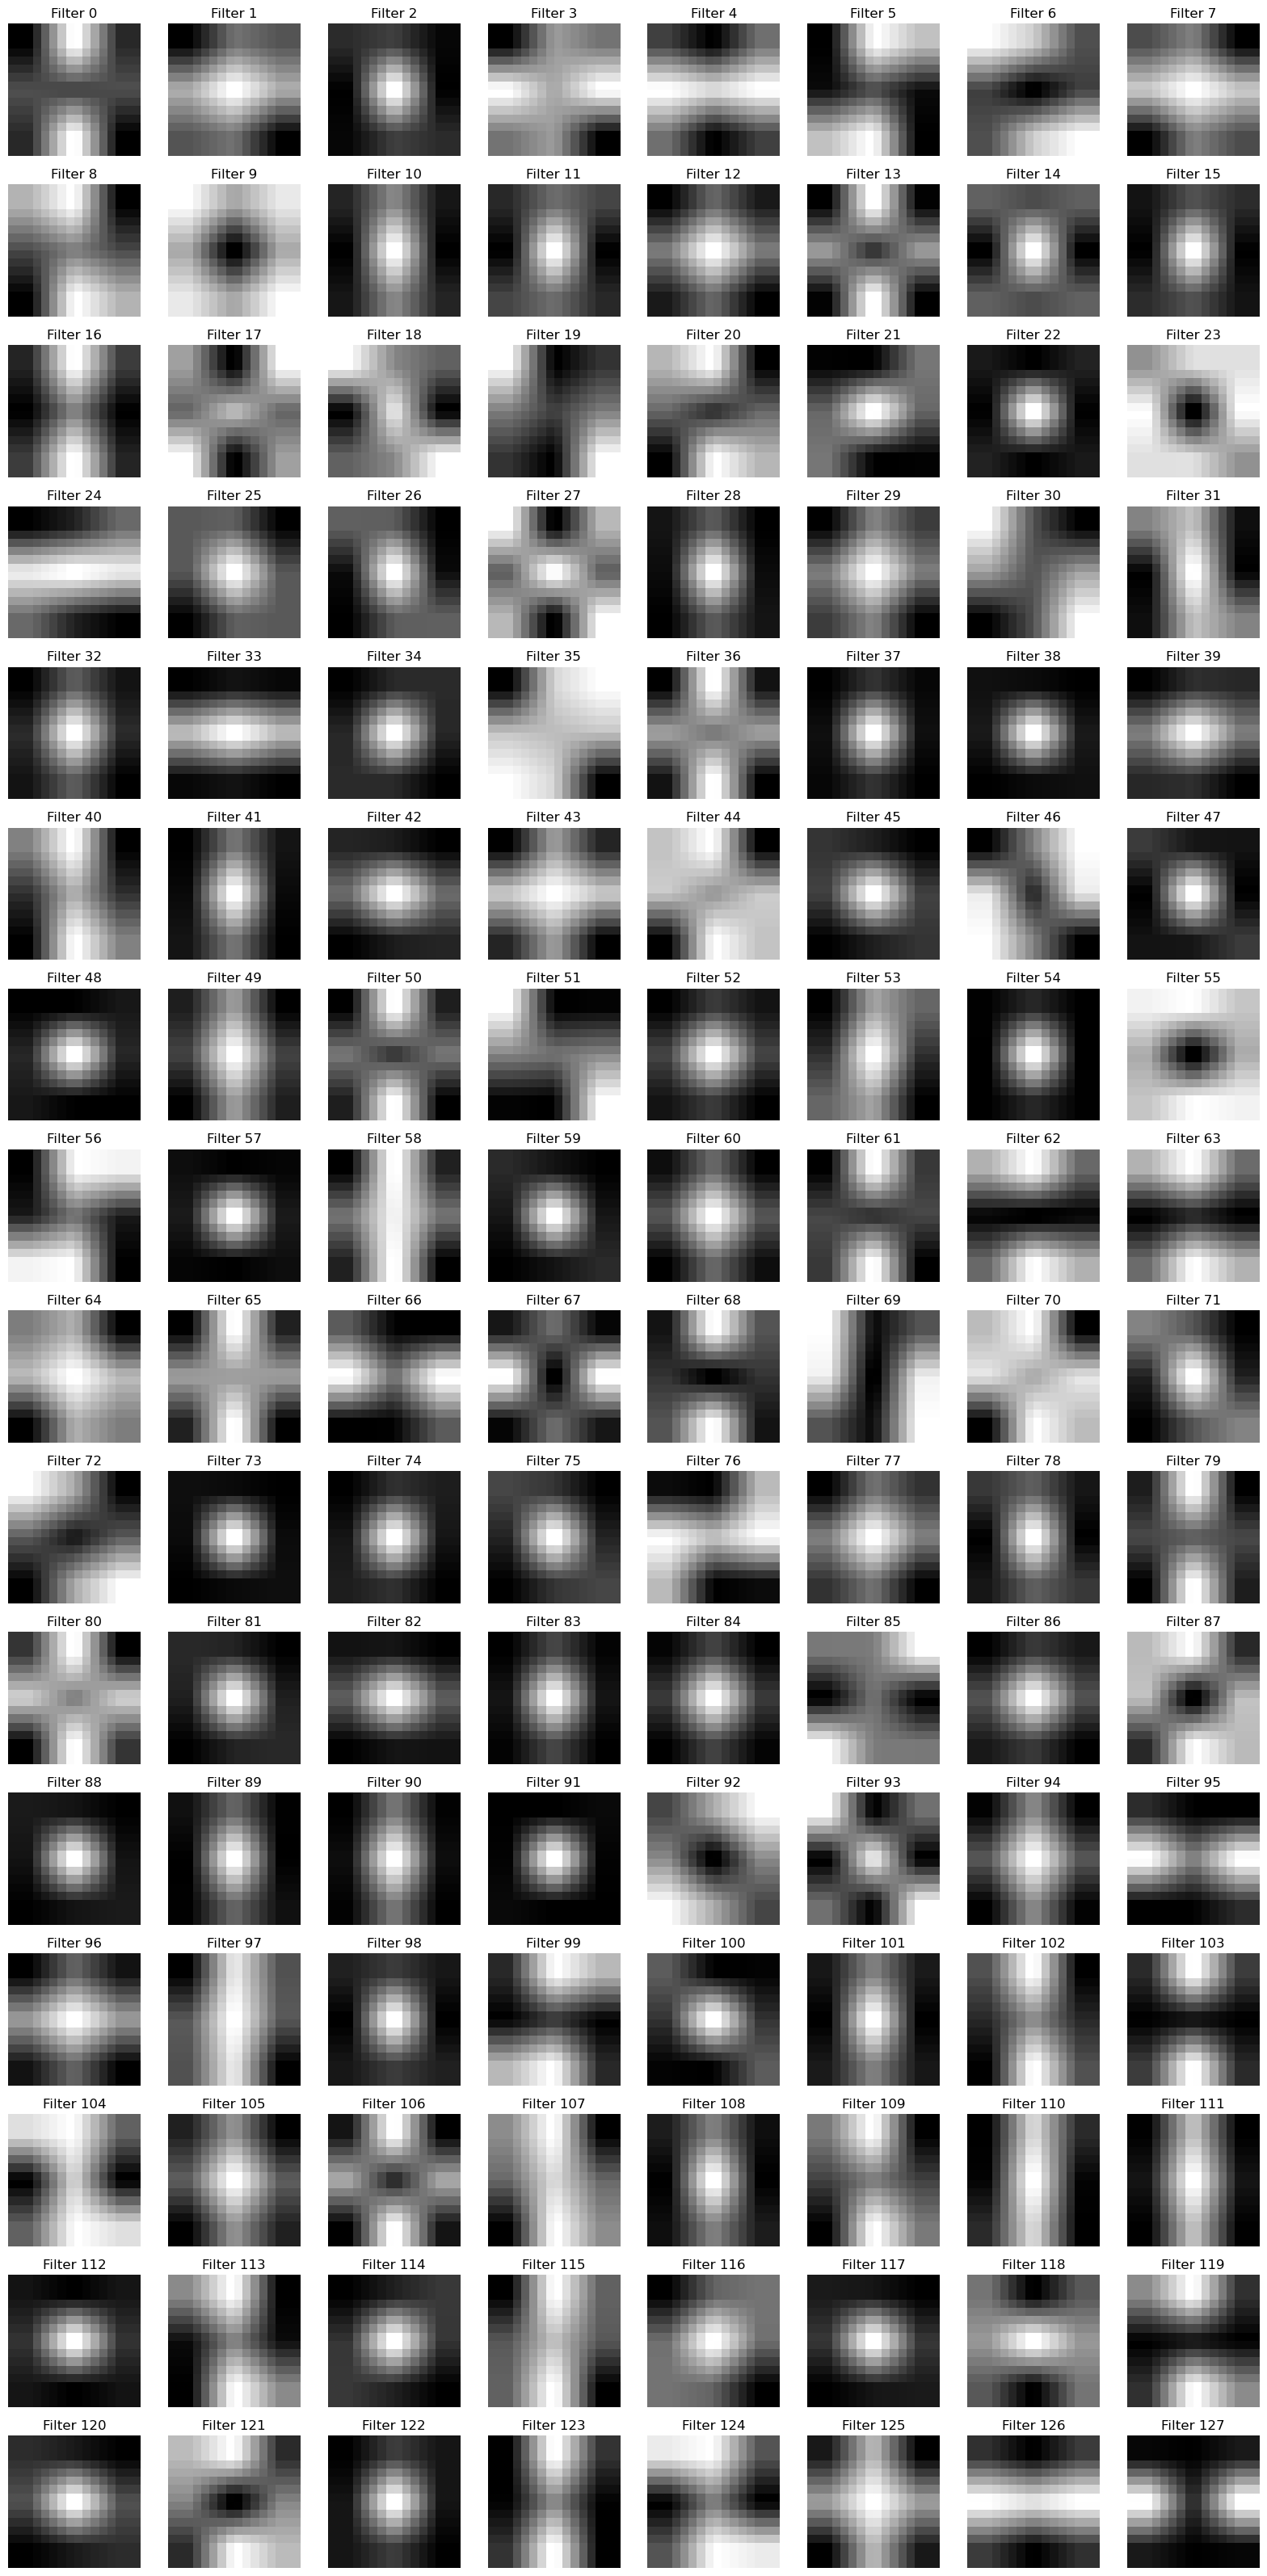

In [17]:
import re
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import torch.fft

def visualize_conv_filters_dft(model, target_name="3.1"):
    # Compile a regex that matches exactly the target_name
    pattern = re.compile(rf"^{re.escape(target_name)}$")
    found_layer = False
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and pattern.fullmatch(name):
            found_layer = True
            print(f"Found Conv2d layer: {name} with weight shape {module.weight.shape}")
            # Extract weights: shape = (out_channels, in_channels, kH, kW)
            weights = module.weight.data.cpu()
            out_channels, in_channels, kH, kW = weights.shape
            # Average over input channels for visualization
            filters = weights.mean(dim=1)  # shape: (out_channels, kH, kW)
            
            n_cols = min(out_channels, 8)
            n_rows = (out_channels + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            for i in range(out_channels):
                filt = filters[i].numpy()
                # Compute the 2D DFT of the filter
                filt_dft = np.fft.fftshift(np.fft.fft2(filt))
                # Compute the magnitude
                filt_dft_mag = np.abs(filt_dft)
                # Resize to 16x16 using interpolation
                filt_dft_mag_resized = np.array(Image.fromarray(filt_dft_mag).resize((16, 16), resample=Image.BILINEAR))
                # Normalize the DFT magnitude for visualization
                filt_dft_mag_resized /= filt_dft_mag_resized.max()
                axes[i].imshow(filt_dft_mag_resized, cmap='gray')
                axes[i].set_title(f"Filter {i}")
                axes[i].axis('off')
            # Hide any extra subplots
            for j in range(out_channels, len(axes)):
                axes[j].axis('off')
            
            # plt.suptitle(f"16x16 DFT Magnitudes in layer: {name}")
            plt.tight_layout()
            plt.show()
    if not found_layer:
        print(f"No Conv2d layers found with name exactly '{target_name}'.")

# Example usage:
visualize_conv_filters_dft(net, target_name="1.1.7.3.1")
